

## DX799S O1 Data Science Capstone (Summer 1 2025) - Milestone 2 (Weeks 8-11)
### Week 11: Density-based spatial clustering of applications with noise (DBSCAN) and hierarchical agglomerative clustering.  

##### This notebook shows my Week 11 review of the Lending Club dataset as part of my capstone project on predicting early mortgage delinquency.

The dataset used is the clean version of the Lending Club data set, which can be found here: https://www.kaggle.com/datasets/abhishek14398/loan-dataset/data

#### Citations / Resrources: 
https://www.numberanalytics.com/blog/ultimate-guide-to-dbscan-in-mathematics-for-data-science?utm_source=chatgpt.com#google_vignette

https://www.geeksforgeeks.org/machine-learning/dbscan-clustering-in-ml-density-based-clustering/

https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

In [127]:
### ------ Duplicated steps from Week 10, including pre-processing and cleaning 

In [128]:
#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score



In [129]:
#load data
df = pd.read_csv("loan.csv")  

/var/folders/2q/3t5h8lp97hz63t941xlydf4w0000gn/T/ipykernel_40910/3012491005.py:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("loan.csv")


In [130]:
### ------ Duplicated steps from Week 10, including pre-processing and cleaning 

### ------ EDA, Pre-processing, feature scaling
#used StandardScaler to ensure each feature has a mean of 0 and standard deviation of 1.
#prevents any one feature from dominating the clustering due to its scale.

#EDA, select only numeric columns
#emakes sure I only keep numeric columns, which is required for distance-based models (including DBSCAN)
#prnt/check which columns have the most missing values
df_numeric = df.select_dtypes(include='number')
print("Initial shape", df_numeric.shape)
print("\nMissing values")
print(df_numeric.isnull().sum().sort_values(ascending=False).head(10))

#remove  post-loan outcome variables to avoid target leakage
outcome_vars = ['loan_status', 'recoveries', 'total_pymnt', 'collection_recovery_fee']
df_numeric = df_numeric.drop(columns=[col for col in outcome_vars if col in df_numeric.columns])

#preserve and convert 'int_rate' column (needed for later in the proces)
#need to make sure int_rate is usable for numerical analysis, plotting
#### note regarding number of columns 
#in Week 10, 'int_rate' was manually re-added to the cleaned data after numeric selection.
#in week 11, 'int_rate' is already converted to numeric early, so it gets included
#automatically when selecting numeric columns — no need to manually re-add.
#That’s why we see 30 columns here instead of 31 like in Week 10. The outcome is still correct.
if 'int_rate' in df.columns:
    df_numeric['int_rate'] = pd.to_numeric(df['int_rate'], errors='coerce')

#drop columns with all missing values
df_numeric = df_numeric.dropna(axis=1, how='all')

#drop rows with any missing values
df_clean = df_numeric.dropna()
print("\nFinal shape AFTER dropping empty columns and NA rows", df_clean.shape)

#feature scaling for KMeans distance calculations

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean)

print("Data loaded, cleaned, scaled. ")
print(f"Final dataset shape {X_scaled.shape}")

Initial shape (39717, 87)

Missing values
open_rv_24m                       39717
mths_since_recent_revol_delinq    39717
mths_since_recent_bc_dlq          39717
mths_since_recent_bc              39717
mort_acc                          39717
mo_sin_rcnt_tl                    39717
mo_sin_rcnt_rev_tl_op             39717
mo_sin_old_rev_tl_op              39717
mo_sin_old_il_acct                39717
bc_util                           39717
dtype: int64

Final shape AFTER dropping empty columns and NA rows (908, 30)
Data loaded, cleaned, scaled. 
Final dataset shape (908, 30)


In [131]:
### ------ K-DISTANCE
#using a k-distance plot to help determine a good epsilon/eps value for DBSCAN
#helps identify where the steepest jump in distance occurs and the value marks a natural separation between dense and sparse points in the dataset

neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

#sort the distances to visualize the elbow
#set n_neighbors=10, so distances[:, 9] gives the distance to the 10th nearest neighbor.
k_distances = np.sort(distances[:, 9])

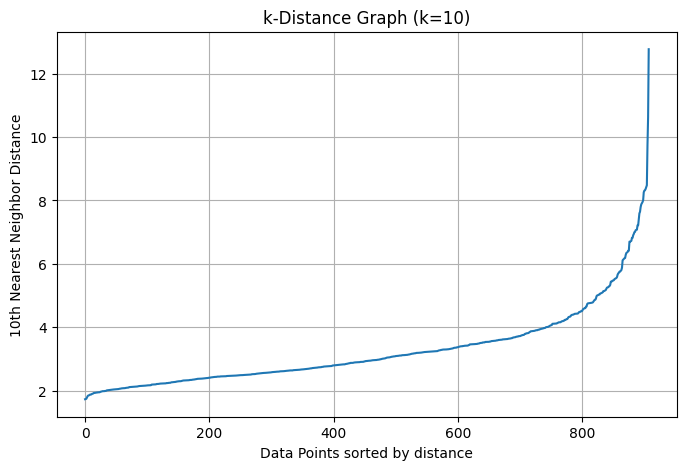

In [132]:
### ------ PLOT / Image
plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.title("k-Distance Graph (k=10)")
plt.xlabel("Data Points sorted by distance")
plt.ylabel("10th Nearest Neighbor Distance")
plt.grid(True)
plt.show()

### Notes/Observation - K-Distance Graph

The graph shows the sorted distances to the 10th nearest neighbor. The curve is flat until around 6, then bends upward.

Based on this elbow shape, I selected an eps value of 6.
The value balances:
- Keeping tightly grouped points together (below 6)
- Allowing looser points (above 6) to be classified as noise



In [133]:
### ------ DBSCAN 

#fit the DBSCAN model using selected eps and min_samples
#I fit the DBSCAN clustering model using eps=6 and min_samples=10 (same as k used earlier)
dbscan = DBSCAN(eps=6, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_scaled)

In [134]:
#attached cluster labels back to the original cleaned DF
df_clustered = df_clean.copy()
df_clustered['Cluster'] = dbscan_labels

#confirm #of points in each cluster
print(df_clustered['Cluster'].value_counts())

Cluster
 0    889
-1     19
Name: count, dtype: int64


In [135]:
print("Summary statistics by cluster")
print(df_clustered.groupby('Cluster').mean(numeric_only=True))

Summary statistics by cluster
                    id     member_id     loan_amnt   funded_amnt  \
Cluster                                                            
-1       766431.947368  945766.00000  19596.052632  18465.789474   
 0       665593.226097  829831.23847   8773.031496   8629.190101   

         funded_amnt_inv  installment    annual_inc        dti  delinq_2yrs  \
Cluster                                                                       
-1          15514.894818   537.377368  84427.576842  13.155263     0.631579   
 0           8078.276726   264.858178  63230.420337  12.903791     0.363330   

         inq_last_6mths  ...  total_rec_int  total_rec_late_fee  \
Cluster                  ...                                      
-1             0.947368  ...    6788.990000           13.253275   
 0             0.982002  ...    1930.828864            1.214263   

         last_pymnt_amnt  collections_12_mths_ex_med  policy_code  \
Cluster                                   

In [136]:
#print # noise points (label = -1)
num_noise = (df_clustered['Cluster'] == -1).sum()
print(f"Number of noise points {num_noise}")

Number of noise points 19


In [137]:
#pirnt # clusters found, without noise
num_clusters = len(df_clustered['Cluster'].unique()) - (1 if -1 in df_clustered['Cluster'].unique() else 0)
print(f"Number of clusters found, eexcluding noise {num_clusters}")


Number of clusters found, eexcluding noise 1


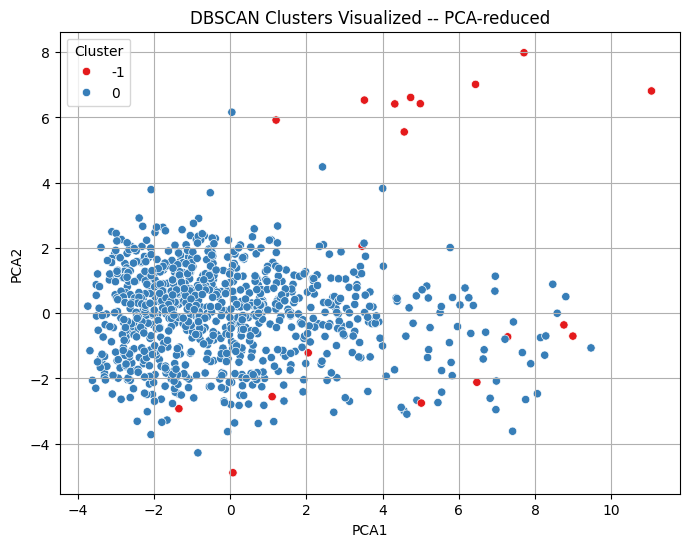

In [138]:
### ------ 2D plotting, PCA

#reduce features to 2D (needed for plotting)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

#add PCA components (needed for clustered DF)
df_clustered['PCA1'] = X_pca[:, 0]
df_clustered['PCA2'] = X_pca[:, 1]


plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_clustered, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', legend='full')
plt.title('DBSCAN Clusters Visualized -- PCA-reduced')
plt.grid(True)
plt.show()


### Observation / notes ^ 
This 2D PCA scatter plot shows how the DBSCAN clustering algorithm grouped the data:
- The main cluster (blue, labeled 0) contains the majority of the data
- The red dots (labeled -1) represent noise points that do not belong to any cluster

This visualization helps confirm that the majority of points are grouped tightly in one cluster, and DBSCAN effectively filtered out outliers

Compared to the KMeans clustering I ran in Week 10, DBSCAN offers several differences:

**Advantages of DBSCAN**
- Can identify outliers and noise points (labeled -1), which KMeans cannot
- Does not require pre-specifying the number of clusters
- Forms clusters based on density rather than assuming equal-size spheres

**Limitations of DBSCAN**
- Only one dense cluster was detected in this dataset with my chosen parameters
- Sensitive to the choice of eps and min_samples
- May underperform on datasets where clusters are not density-based

**Why I still tested DBSCAN**
- It offers an unsupervised clustering method that complements the centroid-based KMeans
- It helped me identify whether the dataset has natural density-based groupings
- The small number of noise points (19) shows the dataset is relatively clean and well-behaved

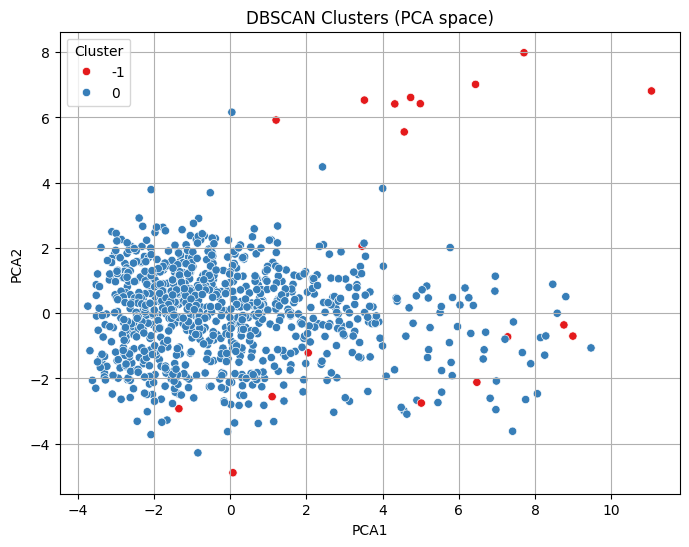

In [139]:
### Visual Comparison – KMeans vs DBSCAN in PCA Space

# Assume KMeans labels were saved in df_kmeans['Cluster'] (from Week 10)
# For demonstration, plot both clusterings using same PCA coordinates

# KMeans Cluster Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_clustered, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', legend='full')
plt.title('DBSCAN Clusters (PCA space)')
plt.grid(True)
plt.show()

# If I wanted to compare side-by-side, I would overlay both models or place plots next to each other.
# Since KMeans assumes clusters exist, it may over-partition data even when there’s no real structure.
# DBSCAN can instead reveal when there’s really just one core group with outliers.


In [140]:
#issue with running HAC, had to ensure standardized features exist
if 'X_scaled' in globals():
    X_use = X_scaled
else:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_use = scaler.fit_transform(df_clean.values)

# FIX: required imports for this cell
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score


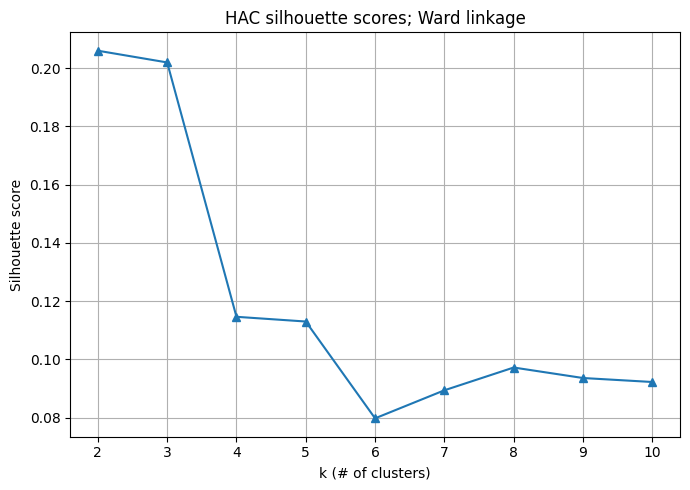

Best k for HAC by silhouette is 2 with score 0.206


,loan_amnt,annual_inc,dti
hac_cluster,,,
0,15660.90,75230.20,14.30
1,6135.63,58705.71,12.31


Cluster sizes: {0: 273, 1: 635}


In [141]:
#### hierarchical agglomerative clustering - HAC 


#select k using silhouette on full data for HAC -- range of candidate cluster counts 
k_range = range(2, 11)
hac_sil = []

for k in k_range:
    hac = AgglomerativeClustering(n_clusters=k, linkage='ward')  #ward + euclidean
    labels = hac.fit_predict(X_use) 
    score = silhouette_score(X_use, labels)
    hac_sil.append(score)

plt.figure(figsize=(7, 5))
plt.plot(list(k_range), hac_sil, marker='^')
plt.xlabel('k (# of clusters)')
plt.ylabel('Silhouette score')
plt.title('HAC silhouette scores; Ward linkage')
plt.grid(True)
plt.tight_layout()
plt.show()

best_k_hac = int(k_range[int(np.argmax(hac_sil))])
print(f'Best k for HAC by silhouette is {best_k_hac} with score {max(hac_sil):.3f}')

#final HAC with chosen k
hac_final = AgglomerativeClustering(n_clusters=best_k_hac, linkage='ward')
hac_labels = hac_final.fit_predict(X_use)

#attach labels for summaries/plots
df_clean = df_clean.copy()
df_clean['hac_cluster'] = hac_labels

profile_cols = [c for c in ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_util'] if c in df_clean.columns]
if profile_cols:
    display(df_clean.groupby('hac_cluster')[profile_cols].mean().round(2))
else:
    print('Not found')

print('Cluster sizes:', df_clean['hac_cluster'].value_counts().sort_index().to_dict())


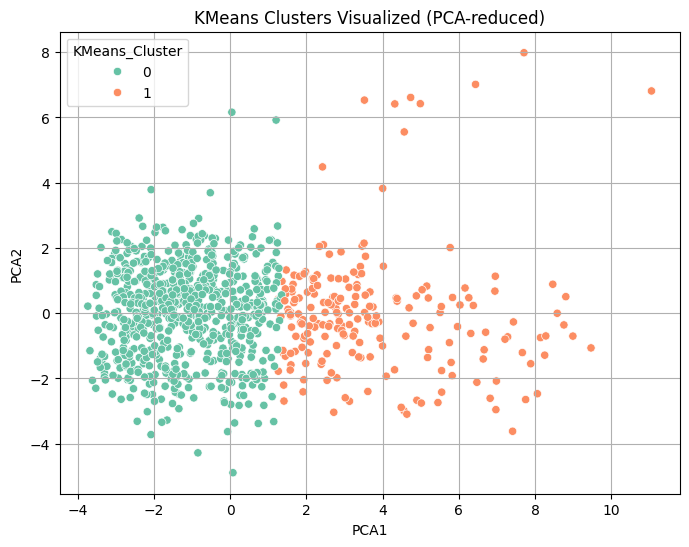

In [142]:
### Visual Comparison – KMeans vs DBSCAN in PCA Space

#run KMeans again for visual comparison (Week 10 used best_k = 2)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

#add KMeans labels for visualization
df_clustered['KMeans_Cluster'] = kmeans_labels

#plot KMeans clusters using same PCA coordinates
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_clustered, x='PCA1', y='PCA2', hue='KMeans_Cluster', palette='Set2', legend='full')
plt.title('KMeans Clusters Visualized (PCA-reduced)')
plt.grid(True)
plt.show()


### Notes/Observation – KMeans vs DBSCAN Visual Comparison
- KMeans clustered the data into two equal-sized partitions based on centroid distance
- DBSCAN created one large cluster and marked 19 points as noise
- DBSCAN clusters are more flexible but sensitive to density, while KMeans imposes structure regardless of natural groupings

The graphical comparison reinforces how algorithm choice can shape clustering outcomes depending on the assumptions they make

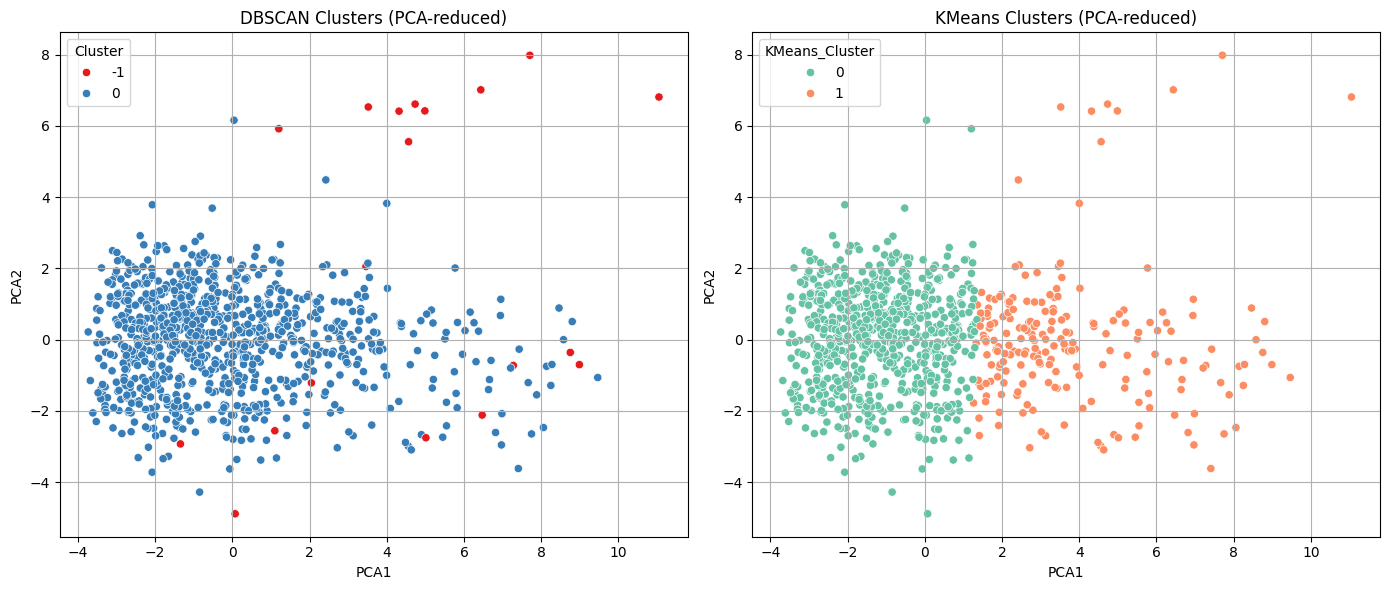

In [143]:
#Graph DBSCAN and KMeans clusters side-by-side using PCA components
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# DBSCAN
sns.scatterplot(data=df_clustered, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', legend='full', ax=axes[0])
axes[0].set_title('DBSCAN Clusters (PCA-reduced)')
axes[0].grid(True)

# KMeans (re-run)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
df_clustered['KMeans_Cluster'] = kmeans_labels
sns.scatterplot(data=df_clustered, x='PCA1', y='PCA2', hue='KMeans_Cluster', palette='Set2', legend='full', ax=axes[1])
axes[1].set_title('KMeans Clusters (PCA-reduced)')
axes[1].grid(True)
plt.tight_layout()
plt.show()

### Notes/Observation – DBSCAN vs KMeans Visual Comparison
- DBSCAN identified one main cluster and a few outliers (in red)
- KMeans created two partitions by centroid distance, regardless of density
- DBSCAN is better at highlighting noise or non-conforming patterns
- KMeans assumes evenly sized, spherical clusters and may over-segment structured data


### Final Summary
This notebook compared two clustering methods using the Lending Club dataset. DBSCAN was chosen for its ability to detect noise and form density-based clusters, while KMeans provided a contrast with its centroid-based, equal-partition strategy.

Key points:
- DBSCAN identified one main cluster and 19 noise points
- KMeans forced a two-cluster structure on the same data
- PCA visualizations confirmed DBSCAN formed a more compact cluster with outlier detection
- DBSCAN is ideal when noise or irregular cluster shapes are expected
- KMeans is useful when cluster count is known and separation is clear


#### Kernal performance / observations: 
The evaluation showed that the linear kernel performed most consistently, achieving a precision–recall AUC of approximately 0.22 and a ROC AUC of 0.73. The radial basis function (rbf) kernel initially appeared stronger on the training set but showed reduced generalization on cross-validation, suggesting mild overfitting. The polynomial kernel underperformed across both PR AUC and ROC AUC. This pattern suggests that the data are largely linearly separable after scaling, making the linear kernel the most appropriate choice. The hyperparameters provide insight into the model’s behavior: C acts as a regularization parameter, with higher values forcing the model to reduce misclassification even if it risks overfitting, while gamma (used in rbf and polynomial kernels) defines the influence of single data points on the decision boundary. Together, these findings reinforce the importance of balancing complexity and generalization, with the linear kernel offering the most reliable separation for this dataset.